<a href="https://colab.research.google.com/github/btrungvo/GAN-finance/blob/main/GAN_Ming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import yfinance as yf
from sklearn import preprocessing
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from typing import Tuple
import torch.nn.functional as F




In [ ]:
print(device)

cuda:0


In [ ]:
def cyclical_encodings(dates: np.ndarray) -> np.ndarray:
    """ Creates cyclical encodings of dates in a year down to hourly diff """
    start = [date(d.year, d.month, d.day) for d in dates]
    delta = np.array([(s-start[0]).days for s in start])
    hours = np.array(dates.hour / 24)
    position = np.array([2 * np.pi * (d+h) / (delta[-1]+1) for d, h in zip(delta, hours)])
    return np.array([np.sin(position), np.cos(position)])

In [ ]:
def fin_time_series(ticker='AAPL', period='2y', interval='1h', cyclical_encoding=False) -> np.ndarray:
    """ Returns normalized prices with corresponding cyclical encodings """
    close_prices = yf.Ticker(ticker).history(period=period, interval=interval)['Close']
    output = preprocessing.normalize([close_prices])
    if cyclical_encoding:
        encodings = cyclical_encodings(close_prices.index)
        output = np.append(output, encodings, axis=0)
    output = np.array([*output]).T
    return output

In [ ]:
# tickers = ['AAL', 'AAPL', 'ABNB', 'ABT', 'ACN', 'ADBE', 'AMD', \
#     'AMZN', 'AXP', 'BA', 'BAC', 'BKNG', 'BLK', 'BMY', 'BP', 'BTI', \
#     'BUD', 'C', 'CAT', 'CMCSA', 'CMG', 'COP', 'COST', 'CRM', \
#     'CSCO', 'CVS', 'CVX', 'DAL', 'DE', 'DELL', 'DIS', 'F', 'FDX', \
#     'GE', 'GILD', 'GM', 'GOOGL', 'GS', 'HD', 'HMC', 'HON', 'HPQ', \
#     'HSBC', 'HYMTF', 'IBM', 'INFY', 'INTC', 'JNJ', 'JPM', 'KO', \
#     'LCID', 'LLY', 'LMT', 'LOW', 'LUV', 'MA', 'MCD', 'MDLZ', \
#     'META', 'MS', 'MSFT', 'MU', 'NIO', 'NKE', 'NVDA', 'ORCL', \
#     'PEP', 'PFE', 'PG', 'PLTR', 'PSNY', 'PYPL', 'QCOM', 'RACE', \
#     'RIVN', 'RTX', 'RY', 'RYAAY', 'SBUX', 'SCHW', 'SHEL', 'SHOP', \
#     'SNY', 'T', 'TGT', 'TM', 'TSLA', 'TSM', 'TXN', 'UAL', 'UBER', \
#     'UBS', 'UL', 'UNH', 'V', 'VZ', 'WFC', 'WM', 'WMT', 'XOM']
tickers=['UL']
train_data = np.array([fin_time_series(ticker=t, period='1y', interval='1d', cyclical_encoding=False) for t in tickers])


In [ ]:
num_noisy_data = 100

In [ ]:
def add_noise(data, noise_level=0.01):
    noise = np.random.randn(*data.shape) * noise_level
    return data + noise

noisy_data = np.vstack([add_noise(train_data, noise_level=0.01) for _ in range(num_noisy_data)])

In [ ]:
# train_dataset = TensorDataset(torch.tensor(train_data))
train_dataset = TensorDataset(torch.tensor(noisy_data))

# Generator using transformer


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.2, device='cpu'):
        super(Generator, self).__init__()
        self.device = torch.device(device)
        self.embedding = nn.Linear(input_dim, hidden_dim).to(self.device)
        # Initialize weights of the embedding layer with Xavier uniform
        nn.init.xavier_uniform_(self.embedding.weight)
        # Add BatchNorm layer after embedding
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim).to(self.device)

        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(hidden_dim, num_heads, batch_first=True).to(self.device),
            num_layers
        ).to(self.device)
        self.layer_norm = nn.LayerNorm(hidden_dim).to(self.device)
        self.fc = nn.Linear(hidden_dim, output_dim).to(self.device)

        # Optionally, add BatchNorm layer after the transformer encoder
        self.batch_norm2 = nn.BatchNorm1d(output_dim).to(self.device)
        self.do = nn.Dropout(p=dropout_rate).to(self.device)

    def forward(self, x):
        x = x.to(self.device)  # Ensure input tensor is on the right device
        x = self.embedding(x)

        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)  # Apply BatchNorm

        x = F.leaky_relu(x)
        x = self.do(x)
        x = self.transformer_encoder(x)
        x = self.layer_norm(x)
        x = self.do(x)
        x = self.fc(x)

        x = self.batch_norm2(x.transpose(1, 2)).transpose(1, 2)  # Apply BatchNorm

        return x

In [ ]:
class ModifiedGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.2, device='cpu'):
        super(ModifiedGenerator, self).__init__()
        self.device = torch.device(device)
        self.embedding = nn.Linear(input_dim, hidden_dim).to(self.device)
        nn.init.xavier_uniform_(self.embedding.weight)

        # Add BatchNorm layer after embedding
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim).to(self.device)

        self.conv1 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1).to(self.device)
        # Increased out_channels for conv2 to hidden_dim * 2
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim * 2, kernel_size=3, padding=1).to(self.device)

        # Adjusted BatchNorm for conv2's output
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim * 2).to(self.device)

        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(hidden_dim * 2, num_heads, batch_first=True).to(self.device),
            num_layers
        ).to(self.device)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2).to(self.device)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim).to(self.device)
        self.fc2 = nn.Linear(hidden_dim, output_dim).to(self.device)
        self.do = nn.Dropout(p=dropout_rate).to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = self.embedding(x)
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)

        x = x.transpose(1, 2)  # Adjust dimensions for Conv1D
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.batch_norm2(x)  # Now correctly configured for the output of conv2

        x = x.transpose(1, 2)  # Adjust dimensions back for transformer encoder
        x = self.do(x)
        x = self.transformer_encoder(x)
        x = self.layer_norm(x)

        x = self.do(x)
        x = self.fc1(x)  # Reduce channel size back to hidden_dim
        x = self.fc2(x)  # Final output layer

        return x


# Discriminator using transformer

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.2, device='cpu'):
        super(Discriminator, self).__init__()
        self.device = torch.device(device)
        self.embedding = nn.Linear(input_dim, hidden_dim).to(self.device)
        nn.init.xavier_uniform_(self.embedding.weight)  # Weight initialization



        # Add 1D convolutional layers
        self.conv1 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1).to(self.device)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1).to(self.device)


        self.batch_norm1 = nn.BatchNorm1d(hidden_dim).to(self.device)  # Batch normalization

        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(hidden_dim, num_heads, batch_first=True).to(self.device),
            num_layers
        )
        self.layer_norm = nn.LayerNorm(hidden_dim).to(self.device)  # Layer normalization

        self.fc = nn.Linear(hidden_dim, 1).to(self.device)
        self.do = nn.Dropout(p=dropout_rate).to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = self.embedding(x)

        x = x.transpose(1,2)
        x = self.conv1(x)
        x = F.leaky_relu(x)  # Activation
        x = self.batch_norm1(x)  # Apply BatchNorm

        x = self.conv2(x)
        x = F.leaky_relu(x)

        x = x.transpose(1,2)

        x = self.do(x)
        x = self.transformer_encoder(x)
        x = self.layer_norm(x)  # Apply LayerNorm

        # x = torch.mean(x, dim=1) # Mean pooling
        # Replacing mean pooling with adaptive max pooling
        x = x.transpose(1, 2)  # Adjust the dimensions for adaptive pooling [N, C, L]
        x = F.adaptive_max_pool1d(x, 1).view(x.size(0), -1)  # Apply adaptive max pooling and flatten

        x = self.do(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

# Define dataloader, generator and discriminator

In [ ]:
batch_size = 32
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
generator = Generator(train_data.shape[-1], 1, 256, 6, 8, device=device)
# generator = ModifiedGenerator(train_data.shape[-1], 1, 256, 6, 8, device=device)

discriminator = Discriminator(train_data.shape[-1], 256, 6, 8, device=device)



# Loss functions

In [ ]:
# Binary Cross Entropy
criterion = nn.BCELoss()


# Start training

In [ ]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

In [ ]:
num_epochs = 50


In [ ]:
generator_losses = []
discriminator_losses = []
synthetic_data = []

In [ ]:
def train_discriminator(discriminator, real_data, fake_data, criterion, optimizer, device):
    optimizer.zero_grad()
    real_labels = torch.ones(real_data.size(0), 1, device=device)
    fake_labels = torch.zeros(fake_data.size(0), 1, device=device)


    # real_loss = compute_loss(discriminator(real_data), 1)
    # fake_loss = compute_loss(discriminator(fake_data.detach()), 0)

    real_loss = criterion(discriminator(real_data), real_labels)
    fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)

    loss = real_loss + fake_loss
    # gradient_penalty = compute_gradient_penalty(discriminator, real_data, fake_data.detach())

    # lambda_gp = 10
    # loss = discriminator(fake_data.detach()) - discriminator(real_data) + lambda_gp * gradient_penalty
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def train_generator(generator, discriminator, fake_data, criterion, optimizer, device):
    optimizer.zero_grad()
    labels = torch.ones(fake_data.size(0), 1, device=device)  # Generator tries to generate real-looking data

    # loss = compute_loss(discriminator(fake_data), 1)

    loss = criterion(discriminator(fake_data), labels)
    # loss =  - discriminator(fake_data)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def generate_noise(batch_size, latent_dim, device):
    """Generates and returns noise suitable for generator input."""
    noise = torch.randn(batch_size, latent_dim, 1, device=device)
    # gaussian_noise = torch.randn(batch_size, latent_dim // 2, 1, device=device)
    # uniform_noise = torch.rand(batch_size, latent_dim // 2, 1, device=device) * 2 - 1  # Uniform noise in [-1, 1]

    # noise = torch.rand(batch_size, latent_dim, 1, device=device)
    # Add any specific noise manipulations here if needed
    return noise


def prepare_real_data_diffs(real_data):
    """Prepares real data differences."""
    initial_value = real_data[:, 0, :].unsqueeze(1)
    successive_diffs = real_data[:, 1:, :] - real_data[:, :-1, :]
    real_data_diffs = torch.cat((initial_value, successive_diffs), dim=1)
    return real_data_diffs


for epoch in range(num_epochs):
    for i, batch in enumerate(data_loader):
        real_data = batch[0].to(device).float()
        current_batch_size = real_data.size(0)  # Dynamic batch size for the current iteration

        real_data_diffs = prepare_real_data_diffs(real_data)


        # Generate noise and fake data

        noise = generate_noise(current_batch_size, real_data.size(1), device=device)
        # noise[:,0,:] *= 0
        # noise = noise.cumsum(1)
        # transformed_real_data = real_data[0][:, 1:].unsqueeze(0).repeat(current_batch_size, 1, 1).to(device)
        # noise = torch.cat((noise, transformed_real_data), 2)


        fake_data_diffs = generator(noise)
        # fake_data_diffs = torch.cat((fake_data_diffs, transformed_real_data), 2) #add cyclical encoding to generated time series

        # Train discriminator
        d_loss = train_discriminator(discriminator, real_data_diffs, fake_data_diffs, criterion, discriminator_optimizer, device)


        # Train generator
        g_loss = train_generator(generator, discriminator, fake_data_diffs, criterion, generator_optimizer, device)

        # Monitor progress
        if i % 10 == 0:  # Adjust based on your preference
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(data_loader)}], Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")
        generator_losses.append(g_loss)
        discriminator_losses.append(d_loss)
        synthetic_data.append(fake_data_diffs)


Epoch [1/50], Batch [1/4], Generator Loss: 5.0728, Discriminator Loss: 1.2319
Epoch [2/50], Batch [1/4], Generator Loss: 0.8833, Discriminator Loss: 1.6553
Epoch [3/50], Batch [1/4], Generator Loss: 0.8236, Discriminator Loss: 1.4558
Epoch [4/50], Batch [1/4], Generator Loss: 0.5387, Discriminator Loss: 1.3872
Epoch [5/50], Batch [1/4], Generator Loss: 0.6070, Discriminator Loss: 1.4208
Epoch [6/50], Batch [1/4], Generator Loss: 0.7107, Discriminator Loss: 1.4084
Epoch [7/50], Batch [1/4], Generator Loss: 0.7850, Discriminator Loss: 1.4412
Epoch [8/50], Batch [1/4], Generator Loss: 0.7620, Discriminator Loss: 1.4002
Epoch [9/50], Batch [1/4], Generator Loss: 0.7072, Discriminator Loss: 1.3891
Epoch [10/50], Batch [1/4], Generator Loss: 0.6473, Discriminator Loss: 1.3780
Epoch [11/50], Batch [1/4], Generator Loss: 0.6730, Discriminator Loss: 1.3780
Epoch [12/50], Batch [1/4], Generator Loss: 0.7182, Discriminator Loss: 1.3895
Epoch [13/50], Batch [1/4], Generator Loss: 0.7194, Discrimin

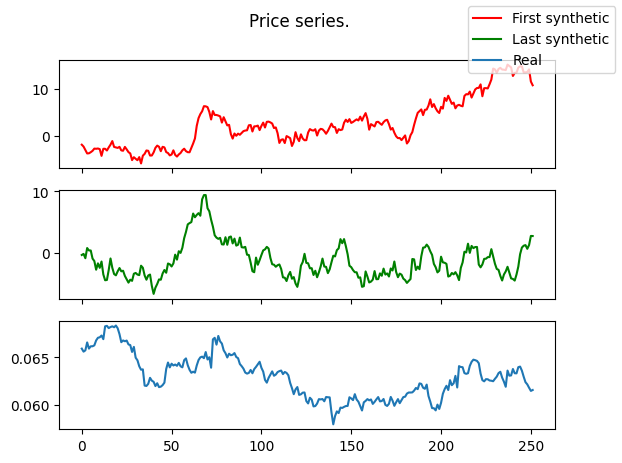

In [ ]:
fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Price series.')
# axs[0].plot(synthetic_data[0][0][:, 0].detach().cpu().numpy(), color='r', label='First synthetic')
# axs[1].plot(synthetic_data[-1][0][:, 0].detach().cpu().numpy(), color='g', label='Last synthetic')
axs[0].plot(torch.cumsum(synthetic_data[0][0][:, 0], dim=0).detach().cpu().numpy(), color='r', label='First synthetic')
axs[1].plot(torch.cumsum(synthetic_data[-1][0][:, 0], dim=0).detach().cpu().numpy(), color='g', label='Last synthetic')
axs[2].plot(train_data[0][:, 0], label='Real')
fig.legend()

for ax in axs:
    ax.label_outer()

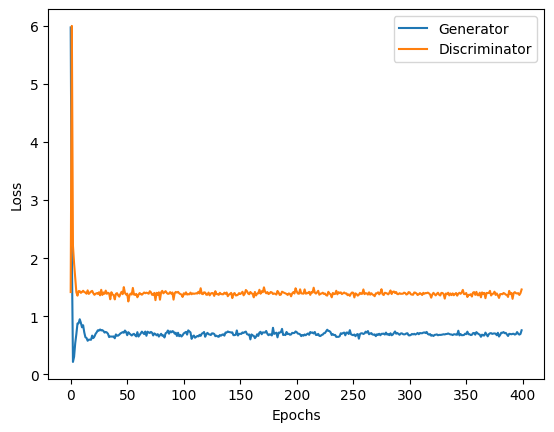

In [ ]:
plt.plot(generator_losses, label='Generator')
plt.plot(discriminator_losses, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()